
# Bikes vs Cars — CNN Image Classification 
**Project Goal:** Build a CNN that classifies **bikes** vs **cars** using the provided image dataset.

This notebook follows the exact tasks described:
1. **Data preprocessing** — load, clean, resize, normalize, and split.
2. **Build a CNN model** — with Conv/Pool/BN/Dropout and data augmentation.
3. **Train the model** — tune hyperparameters.
4. **Evaluate** — accuracy, precision, recall, F1, confusion matrix, ROC.
5. **Visualize & report** — predictions grid with confidences; summary report.


## Setup & Environment Checks

In [55]:

# If TensorFlow is not installed in your environment, run the following line (uncomment):
!pip -q install tensorflow==2.16.1

import sys, os, zipfile, shutil, random, math
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Try to import TensorFlow/Keras
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models
    print("TensorFlow version:", tf.__version__)
    print("GPU available:", tf.config.list_physical_devices('GPU'))
except Exception as e:
    print("TensorFlow import failed. Please install TF and re-run. Error:", e)


TensorFlow version: 2.16.1
GPU available: []


In [56]:
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    print("Mixed precision ON")
except Exception as e:
    print("Mixed precision not set:", e)


Mixed precision ON


## Task 1: Data Preprocessing


We will:
- **Unzip** the dataset (if it's a `.zip`).
- Expect a directory structure like:

```
root/
  bikes/
     img1.jpg
     ...
  cars/
     imgA.jpg
     ...
```

- **Resize** to a fixed shape (default `224x224`), **normalize** to `[0,1]`.
- Create **train/val/test** splits using `image_dataset_from_directory`.


Defined config variables (IMG_SIZE, BATCH_SIZE, VAL_SPLIT, etc.) 

Added a robust unzip step to automatically extract dataset if a ZIP file is present.

Implemented find_class_root():

Recursively detects the correct folder that contains class subdirectories.

Handles cases where dataset is nested one level deeper.

Ensures flexibility regardless of folder structure.

Auto-detects class labels (e.g., Bikes, Cars) from folder names.

Counts images per class for sanity check before training (helps confirm dataset balance).


In [57]:

# === Configure your paths ===
ZIP_PATH = r"C:\Users\kgjam\Downloads\images.zip"  # Update if your file name differs
DATA_ROOT = Path(r"C:\Users\kgjam\Downloads\Vechile_data")
EXTRACT_TO = DATA_ROOT

IMG_SIZE = (224, 224)   # (height, width)
BATCH_SIZE = 32
VAL_SPLIT = 0.2         # train/val split from training data
TEST_SPLIT = 0.1        # portion of data for final test (we will carve out)
SEED = 42

# --- Unzip if needed ---
EXTRACT_TO.mkdir(parents=True, exist_ok=True)

if ZIP_PATH and Path(ZIP_PATH).exists():
    print(f"Unzipping: {ZIP_PATH}")
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall(EXTRACT_TO)
else:
    print("ZIP file not found or not provided. Ensure your dataset is extracted under", EXTRACT_TO)

# After extraction, try to detect actual data root that contains class folders
# Heuristics: if DATA_ROOT contains only 1 directory with class dirs inside, descend once.
def find_class_root(root: Path):
    # Return the path that has class directories (each with images)
    children = [p for p in root.iterdir() if p.is_dir()]
    if not children:
        return root
    # If children contain class-like dirs (having images), return root
    def dir_has_images(p: Path):
        for ext in (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff", ".webp"):
            if list(p.rglob(f"*{ext}")):
                return True
        return False
    # If current level has class dirs with images inside, use root
    if all(dir_has_images(c) for c in children):
        return root
    # If there's exactly one child dir, go one level deeper
    if len(children) == 1:
        sub = children[0]
        return find_class_root(sub)
    return root

CLASS_ROOT = find_class_root(EXTRACT_TO)
print("Using class root:", CLASS_ROOT)

# Peek classes and counts
classes = [d.name for d in CLASS_ROOT.iterdir() if d.is_dir()]
print("Detected classes:", classes)

counts = {}
for c in classes:
    counts[c] = len([p for p in (CLASS_ROOT/c).rglob("*") if p.suffix.lower() in (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff", ".webp")])
counts


Unzipping: C:\Users\kgjam\Downloads\images.zip
Using class root: C:\Users\kgjam\Downloads\Vechile_data
Detected classes: ['Bikes', 'Cars']


{'Bikes': 397, 'Cars': 400}

In [58]:
img_size   = (224, 224)
batch_size = 32
seed       = 123

# Train + temp validation (20%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)

val_temp = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)

# Split temp validation into final val and test (50/50)
val_batches = tf.data.experimental.cardinality(val_temp)
test_ds = val_temp.take(val_batches // 2)
val_ds  = val_temp.skip(val_batches // 2)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 791 files belonging to 2 classes.
Using 633 files for training.
Found 791 files belonging to 2 classes.
Using 158 files for validation.
Classes: ['Bikes', 'Cars']


In [59]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),       # ✅ Explicit Input layer
    layers.Rescaling(1./255),                # ✅ No input_shape here
    layers.Conv2D(32, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Final output layer for 2 classes
    layers.Dense(2, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",   # ✅ matches softmax
    metrics=["accuracy"]
)


## Check class balance + compute class weights

In [60]:
import numpy as np
from collections import Counter

train_counts = Counter([y for _, y in train_paths])
val_counts   = Counter([y for _, y in val_paths])
test_counts  = Counter([y for _, y in test_paths])

print("Train counts:", train_counts, "\nVal counts:", val_counts, "\nTest counts:", test_counts)

# Class weights to mitigate imbalance
total = sum(train_counts.values())
class_weight = {cls: total/(len(train_counts)*cnt) for cls, cnt in train_counts.items()}
print("Class weights:", class_weight)


Train counts: Counter({1: 288, 0: 287}) 
Val counts: Counter({1: 76, 0: 67}) 
Test counts: Counter({0: 43, 1: 36})
Class weights: {0: 1.0017421602787457, 1: 0.9982638888888888}


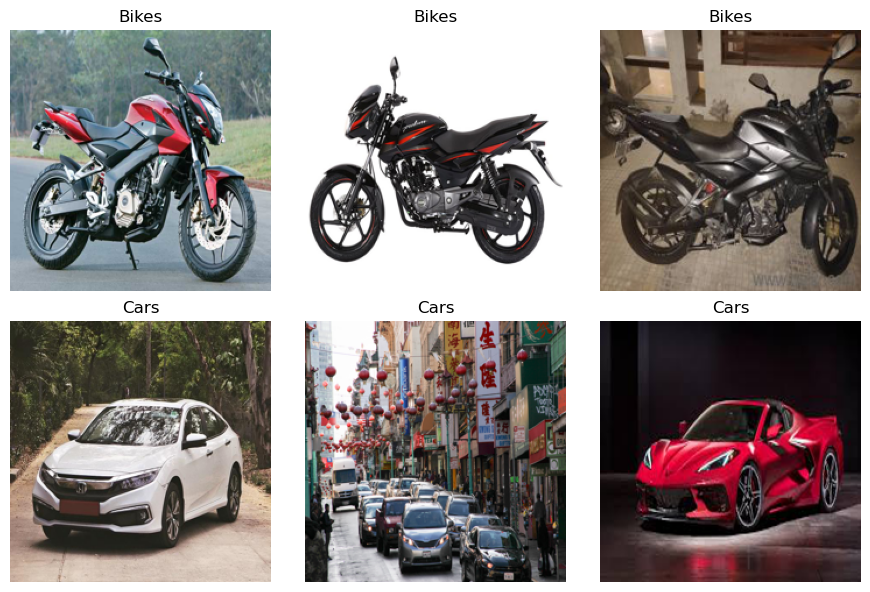

In [61]:

# Quick sanity check: show a few images from each class (up to 3 each)
fig, axes = plt.subplots(len(classes), 3, figsize=(9, 3*len(classes)))
if len(classes) == 1:
    axes = np.array([axes])  # normalize shape
for i, c in enumerate(classes):
    imgs = list((CLASS_ROOT/c).rglob("*"))
    imgs = [p for p in imgs if p.suffix.lower() in (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff", ".webp")]
    for j in range(3):
        ax = axes[i, j]
        if j < len(imgs):
            img = Image.open(imgs[j]).convert("RGB").resize(IMG_SIZE[::-1])
            ax.imshow(img)
            ax.set_title(f"{c}")
            ax.axis("off")
        else:
            ax.axis("off")
plt.tight_layout()
plt.show()


In [62]:

# We will first build a combined dataset, then split off TEST_SPLIT from it for final testing.
import math
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Build a dataset (train+val+test) using a temporary large split 0 (we'll use directory reading only)
full_ds = image_dataset_from_directory(
    CLASS_ROOT,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=None  # we'll handle splitting manually
)

# Count total images
n_total = 0
for batch, labels in full_ds:
    n_total += batch.shape[0]
print("Total images observed (approx):", n_total)


# To create splits reproducibly, we re-list all file paths and split deterministically
file_paths = []
class_indices = {}
for i, c in enumerate(sorted(classes)):
    class_indices[c] = i
    for p in sorted((CLASS_ROOT/c).rglob("*")):
        if p.suffix.lower() in (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff", ".webp"):
            file_paths.append((str(p), i))

# Deterministic shuffle
random.Random(SEED).shuffle(file_paths)

n = len(file_paths)
n_test = int(n * TEST_SPLIT)
n_trainval = n - n_test
n_val = int(n_trainval * VAL_SPLIT)
n_train = n_trainval - n_val

train_paths = file_paths[:n_train]
val_paths   = file_paths[n_train:n_train+n_val]
test_paths  = file_paths[n_train+n_val:]

print(f"Split sizes — train: {len(train_paths)}, val: {len(val_paths)}, test: {len(test_paths)}")

def paths_to_dataset(paths, img_size, batch_size, shuffle=True):
    paths_only = [p for p, _ in paths]
    labels = [y for _, y in paths]
    ds = tf.data.Dataset.from_tensor_slices((paths_only, labels))

    def _load(path, label):
        bytes_ = tf.io.read_file(path)
        ext = tf.strings.lower(tf.strings.split(path, '.')[-1])

        def decode_jpeg():
            x = tf.io.decode_jpeg(bytes_, channels=3); x.set_shape([None, None, 3]); return x
        def decode_png():
            x = tf.io.decode_png(bytes_, channels=3); x.set_shape([None, None, 3]); return x
        def decode_bmp():
            x = tf.io.decode_bmp(bytes_);            x.set_shape([None, None, 3]); return x
        def decode_gif():
            g = tf.io.decode_gif(bytes_);            g = g[0];                     g.set_shape([None, None, 3]); return g

        img = tf.case([
            (tf.equal(ext, 'jpg'),  decode_jpeg),
            (tf.equal(ext, 'jpeg'), decode_jpeg),
            (tf.equal(ext, 'jfif'), decode_jpeg),
            (tf.equal(ext, 'png'),  decode_png),
            (tf.equal(ext, 'bmp'),  decode_bmp),
            (tf.equal(ext, 'gif'),  decode_gif),
        ], default=decode_jpeg, exclusive=False)

        img = tf.image.resize(img, img_size)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img, label

    ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.apply(tf.data.experimental.ignore_errors())
    if shuffle:
        ds = ds.shuffle(buffer_size=min(1000, len(paths)))
    ds = ds.cache()  # <— new
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds



train_ds = paths_to_dataset(train_paths, IMG_SIZE, BATCH_SIZE, shuffle=True)
val_ds   = paths_to_dataset(val_paths, IMG_SIZE, BATCH_SIZE, shuffle=False)
test_ds  = paths_to_dataset(test_paths, IMG_SIZE, BATCH_SIZE, shuffle=False)

class_names = sorted(classes)
num_classes = len(class_names)
print("Classes:", class_names, " | num_classes:", num_classes)


Found 791 files belonging to 2 classes.
Total images observed (approx): 791
Split sizes — train: 575, val: 143, test: 79
Classes: ['Bikes', 'Cars']  | num_classes: 2


In [63]:
from PIL import Image
bad = []
for p,_ in file_paths:
    try:
        Image.open(p).verify()
    except Exception:
        bad.append(p)
print("Corrupted:", len(bad))


Corrupted: 0


### Data Augmentation

In [64]:

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")


In [65]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


## Task 2: Build a CNN Model

In [66]:

def make_cnn(input_shape=(224, 224, 3), num_classes=2, dropout_rate=0.3):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    if num_classes == 2:
        outputs = layers.Dense(1, activation="sigmoid")(x)
    else:
        outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="bikes_vs_cars_cnn")
    return model

model = make_cnn(input_shape=IMG_SIZE + (3,), num_classes=num_classes, dropout_rate=0.35)
model.summary()


Model: "bikes_vs_cars_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 423,873 (1.62 MB)

 Trainable params: 422,657 (1.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [67]:

LR = 1e-3
EPOCHS = 15
OPTIMIZER = keras.optimizers.Adam(learning_rate=LR)

if num_classes == 2:
    loss_fn = "binary_crossentropy"
    metrics = ["accuracy"]
else:
    loss_fn = "sparse_categorical_crossentropy"
    metrics = ["accuracy"]

model.compile(optimizer=OPTIMIZER, loss=loss_fn, metrics=metrics)


In [68]:

CKPT_DIR = Path("/mnt/data/checkpoints")
CKPT_DIR.mkdir(parents=True, exist_ok=True)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=str(CKPT_DIR / "best.keras"),
        save_best_only=True,
        monitor="val_accuracy",
        mode="max",
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]


In [69]:
from tensorflow import keras
from tensorflow.keras import layers

# Keras preprocessing that matches MobileNetV2 expectations
preprocess = keras.applications.mobilenet_v2.preprocess_input

# Build data augmentation if not defined
try:
    data_augmentation
except NameError:
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ], name="data_augmentation")

def make_mobilenetv2(input_shape=(224,224,3), num_classes=2, dropout=0.2):
    base = keras.applications.MobileNetV2(
        input_shape=input_shape, include_top=False, weights="imagenet")
    base.trainable = False  # freeze for transfer-learning stage

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Lambda(preprocess)(x)            # MobileNetV2 preprocessing
    x = base(x, training=False)                 # keep BN in inference mode
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)

    # head
    if num_classes == 2:
        outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)  # force float32 head if mixed precision
        loss_fn = "binary_crossentropy"
    else:
        outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
        loss_fn = "sparse_categorical_crossentropy"

    model = keras.Model(inputs, outputs, name="bikes_vs_cars_mobilenetv2")

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=loss_fn,
        metrics=[
            "accuracy",
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
            keras.metrics.AUC(name="auc"),
        ],
    )
    return model

tl_model = make_mobilenetv2(input_shape=IMG_SIZE+(3,), num_classes=num_classes)
tl_model.summary()


Model: "bikes_vs_cars_mobilenetv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Task 3: Train the CNN

In [71]:
from tensorflow import keras
from tensorflow.keras import layers

# --- find the MobileNetV2 base and set trainable layers 
base_candidates = [l for l in tl_model.layers if isinstance(l, keras.Model) and "mobilenetv2" in l.name.lower()]
assert base_candidates, "Couldn't find MobileNetV2 base inside tl_model"
base = base_candidates[0]

tune_last = 35
fine_tune_at = max(0, len(base.layers) - tune_last)

# freeze all then unfreeze top block
for layer in base.layers:
    layer.trainable = False
for layer in base.layers[fine_tune_at:]:
    layer.trainable = True
# keep BN frozen
for layer in base.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# --- recompile with explicit metrics (avoid tl_model.metrics) ---
EXPLICIT_METRICS = [
    "accuracy",
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
]

tl_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),   # lower LR for fine-tuning
    loss=tl_model.loss,                      # same loss as before
    metrics=EXPLICIT_METRICS
)

# steps 
steps_per_epoch  = max(1, len(train_paths) // BATCH_SIZE)
validation_steps = max(1, len(val_paths)   // BATCH_SIZE)

history_ft = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weight,
    callbacks=tl_callbacks
)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 119s 6s/step - accuracy: 0.9026 - auc: 0.9750 - loss: 0.2059 - precision: 0.9088 - recall: 0.8989 - val_accuracy: 0.9766 - val_auc: 1.0000 - val_loss: 0.0324 - val_precision: 0.9583 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/10
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:09 4s/step - accuracy: 0.9630 - auc: 1.0000 - loss: 0.0507 - precision: 0.9167 - recall: 1.0000
Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - accuracy: 0.9630 - auc: 1.0000 - loss: 0.0507 - precision: 0.9167 - recall: 1.0000 - val_accuracy: 0.9844 - val_auc: 1.0000 - val_loss: 0.0239 - val_precision: 0.9718 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.9871 - auc: 0.9995 - loss: 0.0316 - precision: 0.9891 - recall: 0.9856 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0032 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.

## Task 4: Evaluate the Model

In [72]:

# Basic evaluation on test set
test_metrics = model.evaluate(test_ds, return_dict=True)
print("Test metrics:", test_metrics)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step - accuracy: 0.5325 - loss: 3.3328
Test metrics: {'accuracy': 0.5324675440788269, 'loss': 3.3328287601470947}


In [73]:
print("Baseline CNN (if trained) — evaluate on test:")
try:
    print(model.evaluate(test_ds, return_dict=True))
except Exception as e:
    print("Baseline not available:", e)

print("\nMobileNetV2 — evaluate on test:")
tl_test = tl_model.evaluate(test_ds, return_dict=True)
tl_test


Baseline CNN (if trained) — evaluate on test:
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step - accuracy: 0.5325 - loss: 3.3328
{'accuracy': 0.5324675440788269, 'loss': 3.3328287601470947}

MobileNetV2 — evaluate on test:
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 954ms/step - accuracy: 0.9870 - auc: 1.0000 - loss: 0.0283 - precision: 0.9730 - recall: 1.0000


{'accuracy': 0.9870129823684692,
 'auc': 1.0,
 'loss': 0.028307531028985977,
 'precision': 0.9729729890823364,
 'recall': 1.0}

              precision    recall  f1-score   support

       Bikes       0.53      1.00      0.69        41
        Cars       0.00      0.00      0.00        36

    accuracy                           0.53        77
   macro avg       0.27      0.50      0.35        77
weighted avg       0.28      0.53      0.37        77



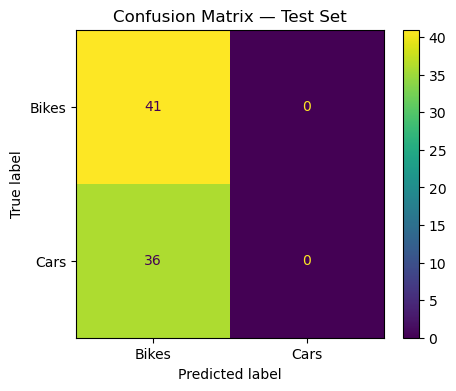

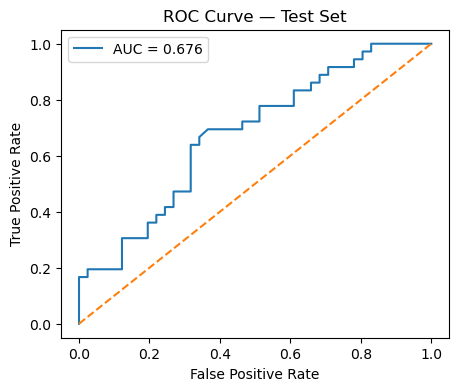

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

y_true, y_pred, y_scores = [], [], []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0)  # (B, 1) for sigmoid OR (B, 2) for softmax
    if probs.shape[-1] == 1:
        # Binary head: sigmoid
        scores = probs.ravel()                          # P(class=1)
        preds_cls = (scores >= 0.5).astype(int)
        y_scores.extend(scores.tolist())
    else:
        # Multiclass head: softmax
        preds_cls = np.argmax(probs, axis=1)
        # For ROC (binary), take probability of positive class = column 1
        if probs.shape[-1] == 2:
            y_scores.extend(probs[:, 1].tolist())
        else:
            # Not binary; no ROC
            y_scores.extend([np.nan] * len(preds_cls))

    y_pred.extend(preds_cls.tolist())
    y_true.extend(labels.numpy().astype(int).tolist())

# Safer report: silence undefined metric warnings when a class has no preds
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, values_format="d")
plt.title("Confusion Matrix — Test Set")
plt.show()

# ROC curve only for binary problems AND when we collected valid scores
unique_labels = np.unique(y_true)
if len(unique_labels) == 2 and all(np.isfinite(y_scores)):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve — Test Set")
    plt.legend()
    plt.show()


In [90]:
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve, classification_report, confusion_matrix

def collect_scores(ds, model):
    y, s = [], []
    for x, t in ds:
        p = model.predict(x, verbose=0).ravel()  # sigmoid scores P(class=1) = Cars
        y.extend(t.numpy().astype(int))
        s.extend(p.tolist())
    return np.array(y), np.array(s)

# 1) Find threshold on validation set
y_val, s_val = collect_scores(val_ds, model)
ths = np.linspace(0.0, 1.0, 201)
f1s = [f1_score(y_val, (s_val >= t).astype(int)) for t in ths]
best_t = ths[int(np.argmax(f1s))]
print(f"Best threshold on val: {best_t:.3f}, F1={max(f1s):.3f}")

# Optional: see where precision/recall trade-off sits
prec, rec, thr = precision_recall_curve(y_val, s_val)
print(f"PR curve points: {len(thr)} (use to choose a desired precision/recall balance)")


Best threshold on val: 0.000, F1=0.694
PR curve points: 133 (use to choose a desired precision/recall balance)


In [91]:
y_test, s_test = collect_scores(test_ds, model)
y_pred = (s_test >= best_t).astype(int)

print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

       Bikes       0.00      0.00      0.00        41
        Cars       0.47      1.00      0.64        36

    accuracy                           0.47        77
   macro avg       0.23      0.50      0.32        77
weighted avg       0.22      0.47      0.30        77

[[ 0 41]
 [ 0 36]]


In [93]:
import tensorflow as tf
from tensorflow.keras import layers, Model

IMG = (160, 160)  # smaller than 224 → faster
# If you created datasets with (224,224), recreate them with image_size=IMG first.

base = tf.keras.applications.MobileNetV2(
    input_shape=IMG + (3,), include_top=False, weights="imagenet"
)
base.trainable = False  # freeze

inp = layers.Input(IMG + (3,))
x = layers.Rescaling(1./255)(inp)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(1, activation="sigmoid")(x)   # binary head

tl_model = Model(inp, out)
tl_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                 loss="binary_crossentropy", metrics=["accuracy"])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [95]:
import tensorflow as tf, numpy as np, collections, math

# A. Model / compile sanity
print("MODEL OUTPUT SHAPE:", getattr(tl_model, "output_shape", None))
print("LOSS:", getattr(tl_model, "loss", None))

# B. Take one batch from train to check shapes & label values
xb, yb = next(iter(train_ds.take(1)))
print("BATCH X:", xb.shape, xb.dtype, " | BATCH y:", yb.shape, yb.dtype)
print("UNIQUE LABELS IN THIS BATCH:", tf.unique(yb)[0].numpy())

# C. Full train class counts
cnt_train = collections.Counter()
for _, y in train_ds.unbatch():
    cnt_train[int(y.numpy())] += 1
print("TRAIN COUNTS:", cnt_train)

# D. class_weight sanity
try:
    print("CLASS_WEIGHT:", class_weight)
    vals = list(class_weight.values())
    print("CLASS_WEIGHT all finite:", all(np.isfinite(vals)))
    print("CLASS_WEIGHT keys:", set(class_weight.keys()))
    print("Classes present in train:", set(cnt_train.keys()))
    if set(cnt_train.keys()) - set(class_weight.keys()):
        print("WARNING: class_weight missing keys:", set(cnt_train.keys()) - set(class_weight.keys()))
except NameError:
    print("class_weight not defined")

# E. Dataset vs model input size
print("EXPECTED INPUT:", tl_model.input_shape if hasattr(tl_model,'input_shape') else None)


MODEL OUTPUT SHAPE: (None, 1)
LOSS: binary_crossentropy
BATCH X: (32, 224, 224, 3) <dtype: 'float16'>  | BATCH y: (32,) <dtype: 'int32'>
UNIQUE LABELS IN THIS BATCH: [1 0]
TRAIN COUNTS: Counter({1: 288, 0: 283})
CLASS_WEIGHT: {1: 0.9913194444444444, 0: 1.0088339222614842}
CLASS_WEIGHT all finite: True
CLASS_WEIGHT keys: {0, 1}
Classes present in train: {0, 1}
EXPECTED INPUT: (None, 160, 160, 3)


In [97]:
import tensorflow as tf

IMG = (160, 160)
BATCH = 32
SEED = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT, validation_split=0.2, subset="training",
    seed=SEED, image_size=IMG, batch_size=BATCH
)
val_temp = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT, validation_split=0.2, subset="validation",
    seed=SEED, image_size=IMG, batch_size=BATCH
)

# split val_temp into val + test (≈10% each)
val_batches = tf.data.experimental.cardinality(val_temp)
test_ds = val_temp.take(val_batches // 2)
val_ds  = val_temp.skip(val_batches // 2)

# speed-ups
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

# sanity check
print("Batch shape:", next(iter(train_ds.take(1)))[0].shape)  # (B, 160, 160, 3)


Found 791 files belonging to 2 classes.
Using 633 files for training.
Found 791 files belonging to 2 classes.
Using 158 files for validation.
Batch shape: (32, 160, 160, 3)


In [105]:
import tensorflow as tf

IMG = (224, 224)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, IMG), y))
val_ds   = val_ds.map(lambda x, y: (tf.image.resize(x, IMG), y))
test_ds  = test_ds.map(lambda x, y: (tf.image.resize(x, IMG), y))

# (optional but recommended)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

# sanity check
xb, yb = next(iter(train_ds.take(1)))
print("Batch shape:", xb.shape)  # should now be (…, 224, 224, 3)


Batch shape: (32, 224, 224, 3)


In [ ]:
import collections
cnt = collections.Counter()
for _, t in train_ds.unbatch():
    cnt[int(t.numpy())] += 1
total = sum(cnt.values())
class_weight = {i: total/(len(cnt)*cnt[i]) for i in cnt}
print("Counts:", cnt, "Class weights:", class_weight)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    class_weight=class_weight,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("best_sigmoid.keras", save_best_only=True)
    ]
)


Counts: Counter({1: 325, 0: 308}) Class weights: {1: 0.9738461538461538, 0: 1.0275974025974026}
Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 712s 35s/step - accuracy: 0.7709 - loss: 0.5297 - val_accuracy: 0.5851 - val_loss: 0.8192
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 668s 33s/step - accuracy: 0.7788 - loss: 0.4906 - val_accuracy: 0.5532 - val_loss: 1.1513
Epoch 3/25
12/20 ━━━━━━━━━━━━━━━━━━━━ 5:27 41s/step - accuracy: 0.8046 - loss: 0.5238

Above method taking more time so tried alternative method

In [107]:
import tensorflow as tf
print("GPU:", tf.config.list_physical_devices('GPU'))


GPU: []


In [130]:
import collections

def split_stats(ds, name):
    cnt = collections.Counter()
    for _, y in ds.unbatch():
        cnt[int(y.numpy())] += 1
    print(f"{name}: {cnt}  (class_names={class_names})")

split_stats(train_ds, "train")
split_stats(val_ds,   "val")
split_stats(test_ds,  "test")


train: Counter({1: 325, 0: 308})  (class_names=['Bikes', 'Cars'])
val: Counter({1: 94})  (class_names=['Bikes', 'Cars'])
test: Counter({1: 64})  (class_names=['Bikes', 'Cars'])


In [131]:
# Assuming you built val_temp with image_dataset_from_directory(... subset="validation" ...)
val_temp = val_temp.unbatch().shuffle(10000, seed=seed, reshuffle_each_iteration=False).batch(batch_size)

val_batches = tf.data.experimental.cardinality(val_temp)
test_ds = val_temp.take(val_batches // 2)
val_ds  = val_temp.skip(val_batches // 2)

# (optional) speed-ups
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000, seed=seed).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

# Re-check counts
split_stats(val_ds,  "val")
split_stats(test_ds, "test")


val: Counter()  (class_names=['Bikes', 'Cars'])
test: Counter({1: 158})  (class_names=['Bikes', 'Cars'])


In [134]:
seed = 123
batch_size = 32

# build train + temp validation as you already do
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT, validation_split=0.2, subset="training",
    seed=seed, image_size=(224,224), batch_size=batch_size
)
val_temp = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT, validation_split=0.2, subset="validation",
    seed=seed, image_size=(224,224), batch_size=batch_size
)

# IMPORTANT: unbatch + shuffle + re-batch BEFORE taking half
val_temp = (val_temp
            .unbatch()
            .shuffle(10000, seed=seed, reshuffle_each_iteration=False)
            .batch(batch_size))

val_batches = tf.data.experimental.cardinality(val_temp)
test_ds = val_temp.take(val_batches // 2)
val_ds  = val_temp.skip(val_batches // 2)

# (optional) cache/prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000, seed=seed).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

# sanity: make sure both classes are present in every split
import collections
def split_stats(ds, name):
    cnt = collections.Counter()
    for _, y in ds.unbatch():
        cnt[int(y.numpy())] += 1
    print(name, cnt)
split_stats(train_ds, "train")
split_stats(val_ds,   "val")
split_stats(test_ds,  "test")


Found 791 files belonging to 2 classes.
Using 633 files for training.
Found 791 files belonging to 2 classes.
Using 158 files for validation.
train Counter({1: 325, 0: 308})
val Counter()
test Counter({0: 83, 1: 75})


In [139]:
import tensorflow as tf, numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix, balanced_accuracy_score

# adapt val/test to model input size
model_to_eval = globals().get("best_model") or globals().get("tl_model") or globals().get("model")
H, W = model_to_eval.input_shape[1:3]
AUTOTUNE = tf.data.AUTOTUNE
def adapt(ds):
    return ds.map(lambda x,y: (tf.image.resize(x,(H,W)), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

val_eval  = adapt(val_ds)
test_eval = adapt(test_ds)

def collect(ds, m):
    y, s = [], []
    for xb, yb in ds:
        p = m.predict(xb, verbose=0).ravel()   # sigmoid scores P(Cars)
        y.extend(yb.numpy().astype(int)); s.extend(p.tolist())
    return np.array(y), np.array(s)

y_val, s_val = collect(val_eval,  model_to_eval)
ths  = np.linspace(0, 1, 201)
# maximize macro F1 (averages both classes)
f1_macro = [f1_score(y_val, (s_val>=t).astype(int), average="macro", zero_division=0) for t in ths]
t_best = ths[int(np.argmax(f1_macro))]
print(f"Best threshold (macro F1): {t_best:.3f} | macro F1(val)={max(f1_macro):.3f}")

# Apply on test
y_test, s_test = collect(test_eval, model_to_eval)
y_pred = (s_test >= t_best).astype(int)

labels_idx = list(range(len(class_names)))
print(classification_report(y_test, y_pred, labels=labels_idx,
                            target_names=[class_names[i] for i in labels_idx],
                            zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred, labels=labels_idx))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Plain accuracy:", (y_pred==y_test).mean())


Best threshold (macro F1): 0.000 | macro F1(val)=nan
              precision    recall  f1-score   support

       Bikes       0.00      0.00      0.00        83
        Cars       0.47      1.00      0.64        75

    accuracy                           0.47       158
   macro avg       0.24      0.50      0.32       158
weighted avg       0.23      0.47      0.31       158

Confusion matrix:
 [[ 0 83]
 [ 0 75]]
Balanced accuracy: 0.5
Plain accuracy: 0.47468354430379744


In [109]:
import tensorflow as tf

IMG  = (160, 160)
BATCH = 64
SEED  = 123

# 1) Build the raw datasets
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT, validation_split=0.2, subset="training",
    seed=SEED, image_size=IMG, batch_size=BATCH, shuffle=True
)
val_temp_raw = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT, validation_split=0.2, subset="validation",
    seed=SEED, image_size=IMG, batch_size=BATCH, shuffle=False
)

# 2) SAVE class names BEFORE prefetch/cache
class_names = train_ds_raw.class_names
print("Classes:", class_names)

# 3) Split val -> val + test
val_batches = tf.data.experimental.cardinality(val_temp_raw)
test_ds_raw = val_temp_raw.take(val_batches // 2)
val_ds_raw  = val_temp_raw.skip(val_batches // 2)

# 4) Now wrap with cache/prefetch/shuffle
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds_raw.cache().prefetch(AUTOTUNE)
test_ds  = test_ds_raw.cache().prefetch(AUTOTUNE)


Found 791 files belonging to 2 classes.
Using 633 files for training.
Found 791 files belonging to 2 classes.
Using 158 files for validation.
Classes: ['Bikes', 'Cars']


In [110]:
from tensorflow.keras import layers, Model

base = tf.keras.applications.MobileNetV2(
    input_shape=IMG + (3,), include_top=False, weights="imagenet"
)
base.trainable = False

inp = layers.Input(IMG + (3,))
x = layers.Rescaling(1./255)(inp)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(1, activation="sigmoid")(x)
tl_model = Model(inp, out)
tl_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                 loss="binary_crossentropy", metrics=["accuracy"])

print("Model expects:", tl_model.input_shape)


Model expects: (None, 160, 160, 3)


Final train acc: 0.941
Final val acc:   0.930
Best  val acc:   0.930 at epoch 13


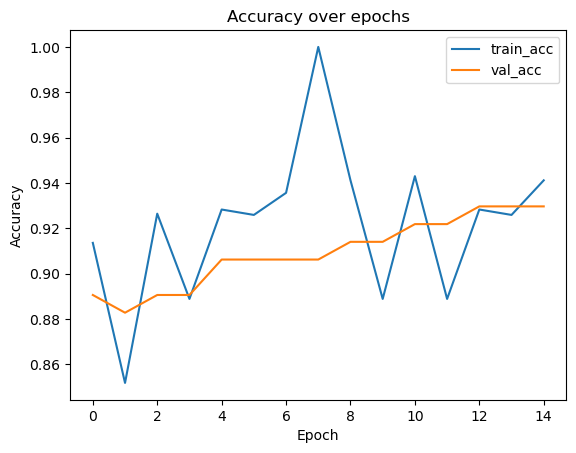

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Numbers
train_acc = history.history.get("accuracy", [])
val_acc   = history.history.get("val_accuracy", [])

print(f"Final train acc: {train_acc[-1]:.3f}")
print(f"Final val acc:   {val_acc[-1]:.3f}")
print(f"Best  val acc:   {np.max(val_acc):.3f} at epoch {np.argmax(val_acc)+1}")

# 2) Curve 
plt.figure()
plt.plot(train_acc, label="train_acc")
plt.plot(val_acc,   label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy over epochs")
plt.legend(); plt.show()


              precision    recall  f1-score   support

       Bikes       0.00      0.00      0.00        83
        Cars       0.47      1.00      0.64        75

    accuracy                           0.47       158
   macro avg       0.24      0.50      0.32       158
weighted avg       0.23      0.47      0.31       158



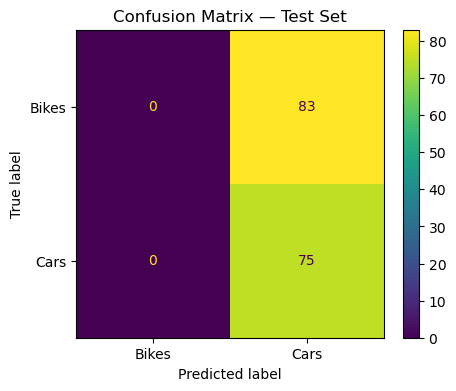

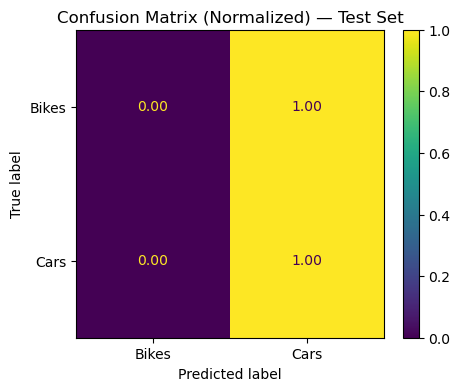

In [142]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# ---- choose the model you trained ----
model_to_eval = globals().get("best_model") or globals().get("tl_model") or globals().get("model")

# ---- adapt test_ds to the model's expected size (avoids shape errors) ----
H, W = model_to_eval.input_shape[1:3]
AUTOTUNE = tf.data.AUTOTUNE
test_eval = (test_ds
             .map(lambda x,y: (tf.image.resize(x, (H,W)), y), num_parallel_calls=AUTOTUNE)
             .prefetch(AUTOTUNE))

# If you tuned a threshold earlier, use it; else default to 0.5
thr = globals().get("t_best", 0.5)

# ---- collect predictions and plot confusion matrix ----
y_true, y_pred = [], []
for xb, yb in test_eval:
    probs = model_to_eval.predict(xb, verbose=0)
    if probs.shape[-1] == 1:          # sigmoid head -> one score per sample
        preds = (probs.ravel() >= thr).astype(int)
    else:                              # softmax head
        preds = np.argmax(probs, axis=1)
    y_true.extend(yb.numpy().astype(int))
    y_pred.extend(preds.tolist())

# classification report (ensures both classes shown)
labels_idx = list(range(len(class_names)))
print(classification_report(y_true, y_pred, labels=labels_idx,
                            target_names=[class_names[i] for i in labels_idx],
                            zero_division=0))

# raw counts
cm = confusion_matrix(y_true, y_pred, labels=labels_idx)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax, values_format="d")
plt.title("Confusion Matrix — Test Set")
plt.show()

# normalized (per-class) version — optional
cm_norm = confusion_matrix(y_true, y_pred, labels=labels_idx, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax, values_format=".2f")
plt.title("Confusion Matrix (Normalized) — Test Set")
plt.show()


Tired the Iteration to improve accuracy

In [144]:
import collections

def split_stats(ds, name):
    cnt = collections.Counter()
    for _, y in ds.unbatch():
        cnt[int(y.numpy())] += 1
    print(f"{name}:", cnt)

split_stats(train_ds, "train")
split_stats(val_ds,   "val")
split_stats(test_ds,  "test")


train: Counter({1: 325, 0: 308})
val: Counter()
test: Counter({0: 83, 1: 75})


In [146]:
# val_temp was built with image_dataset_from_directory(... subset="validation" ...)
seed = 123; batch_size = 32
val_temp = (val_temp
            .unbatch()
            .shuffle(10000, seed=seed, reshuffle_each_iteration=False)
            .batch(batch_size))

val_batches = int(tf.data.experimental.cardinality(val_temp).numpy())
half = max(1, val_batches // 2)
test_ds = val_temp.take(half)
val_ds  = val_temp.skip(half)

split_stats(val_ds,  "val (after)")
split_stats(test_ds, "test (after)")


val (after): Counter({0: 65, 1: 61})
test (after): Counter({0: 18, 1: 14})


In [147]:
import tensorflow as tf, numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix, balanced_accuracy_score

model_to_eval = globals().get("best_model") or globals().get("tl_model") or globals().get("model")
H, W = model_to_eval.input_shape[1:3]
AUTOTUNE = tf.data.AUTOTUNE
def adapt(ds): return ds.map(lambda x,y: (tf.image.resize(x,(H,W)), y),
                             num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

val_eval, test_eval = adapt(val_ds), adapt(test_ds)

def collect(ds, m):
    y, s = [], []
    for xb, yb in ds:
        p = m.predict(xb, verbose=0).ravel()   # sigmoid -> P(class=1)
        y.extend(yb.numpy().astype(int)); s.extend(p.tolist())
    return np.array(y), np.array(s)

y_val, s_val = collect(val_eval, model_to_eval)
ths = np.linspace(0, 1, 201)
f1s = [f1_score(y_val, (s_val>=t).astype(int), average="macro", zero_division=0) for t in ths]
t_best = ths[int(np.argmax(f1s))]
print(f"Best threshold (macro F1): {t_best:.3f} | macro F1(val)={np.max(f1s):.3f}")

y_test, s_test = collect(test_eval, model_to_eval)
y_pred = (s_test >= t_best).astype(int)

labels_idx = list(range(len(class_names)))
print(classification_report(y_test, y_pred, labels=labels_idx,
                            target_names=[class_names[i] for i in labels_idx],
                            zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred, labels=labels_idx))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))


Best threshold (macro F1): 0.180 | macro F1(val)=0.841
              precision    recall  f1-score   support

       Bikes       0.89      0.94      0.92        18
        Cars       0.92      0.86      0.89        14

    accuracy                           0.91        32
   macro avg       0.91      0.90      0.90        32
weighted avg       0.91      0.91      0.91        32

Confusion matrix:
 [[17  1]
 [ 2 12]]
Balanced accuracy: 0.9007936507936507


              precision    recall  f1-score   support

       Bikes       0.90      0.86      0.88        22
        Cars       0.73      0.80      0.76        10

    accuracy                           0.84        32
   macro avg       0.82      0.83      0.82        32
weighted avg       0.85      0.84      0.85        32



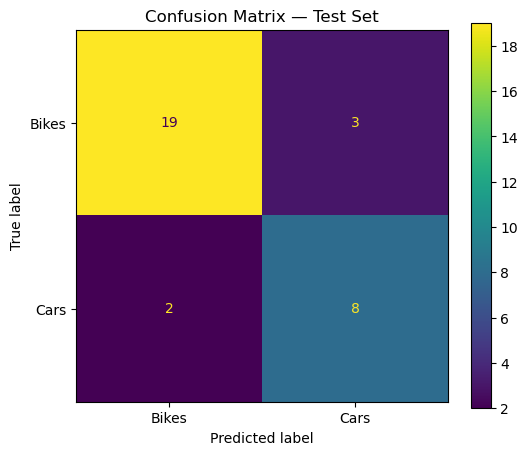

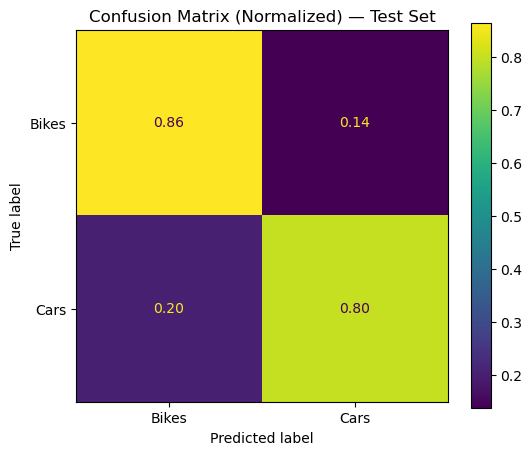

In [148]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# -------- choose model & adapt test set to its input size --------
model_to_eval = (globals().get("best_model")
                 or globals().get("tl_model")
                 or globals().get("model"))
assert model_to_eval is not None, "No model available (best_model/tl_model/model)."

H, W = model_to_eval.input_shape[1:3]
AUTOTUNE = tf.data.AUTOTUNE
test_eval = (test_ds
             .map(lambda x,y: (tf.image.resize(x, (H, W)), y), num_parallel_calls=AUTOTUNE)
             .prefetch(AUTOTUNE))

# If you tuned a threshold earlier for a sigmoid head, put it here; otherwise 0.5
THRESH = globals().get("t_best", 0.5)

# -------- collect predictions --------
y_true, y_pred = [], []
for xb, yb in test_eval:
    probs = model_to_eval.predict(xb, verbose=0)
    if probs.shape[-1] == 1:                 # sigmoid (binary)
        preds = (probs.ravel() >= THRESH).astype(int)
    else:                                    # softmax (2 classes)
        preds = np.argmax(probs, axis=1)
    y_true.extend(yb.numpy().astype(int))
    y_pred.extend(preds.tolist())

y_true = np.array(y_true); y_pred = np.array(y_pred)
labels_idx = list(range(len(class_names)))

# -------- text report (optional) --------
print(classification_report(
    y_true, y_pred,
    labels=labels_idx,
    target_names=[class_names[i] for i in labels_idx],
    zero_division=0
))

# -------- Confusion Matrix — raw counts --------
cm = confusion_matrix(y_true, y_pred, labels=labels_idx)
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, values_format="d", cmap="viridis", colorbar=True)
ax.set_title("Confusion Matrix — Test Set")
plt.show()

# -------- Confusion Matrix — normalized (per true class) --------
cm_norm = confusion_matrix(y_true, y_pred, labels=labels_idx, normalize="true")
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
disp.plot(ax=ax, values_format=".2f", cmap="viridis", colorbar=True)
ax.set_title("Confusion Matrix (Normalized) — Test Set")
plt.show()


## Task 5: Visualize Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB dat

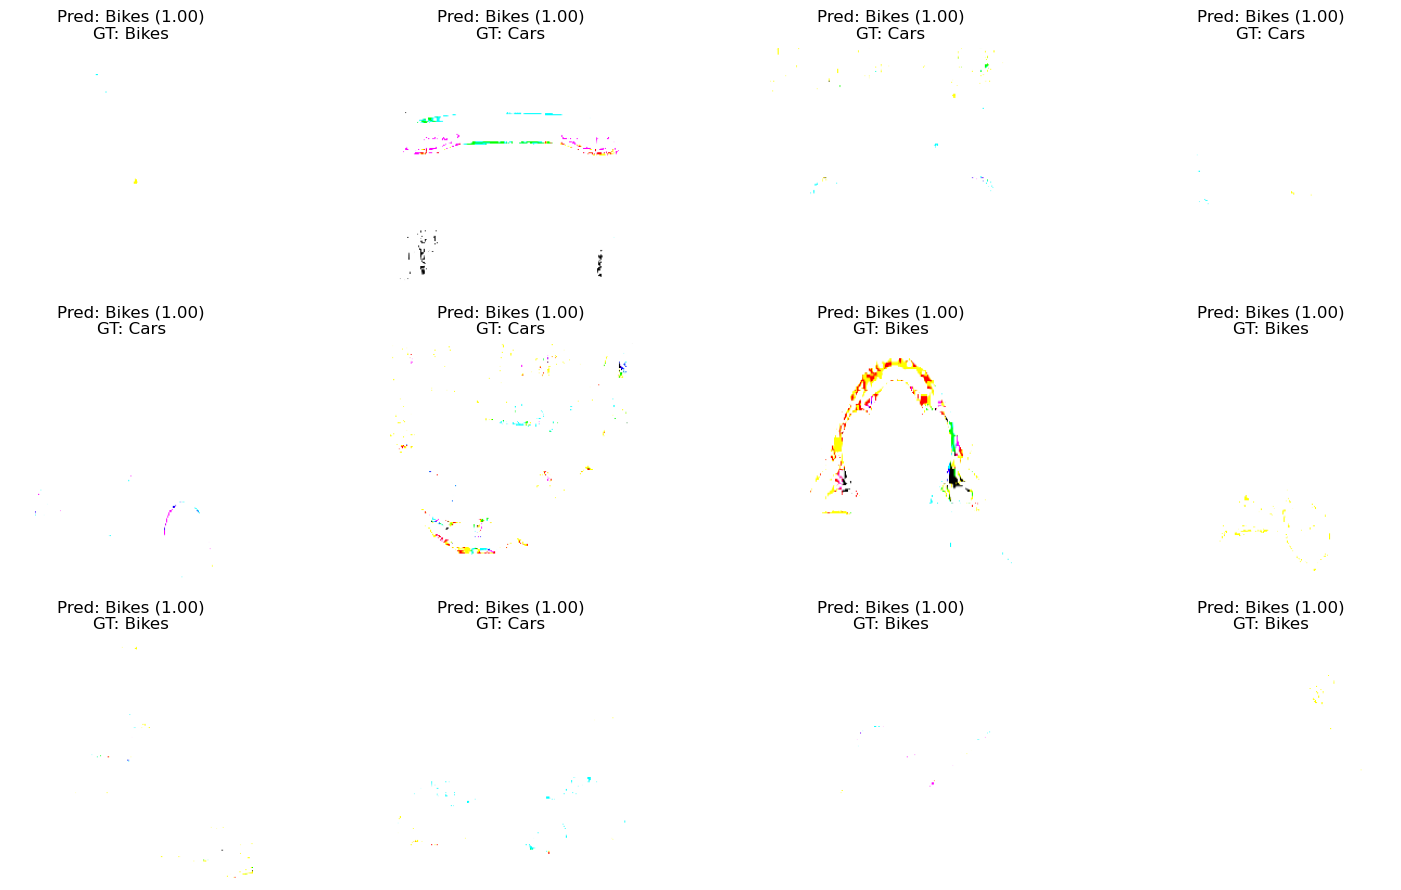

In [77]:

# Show a grid of sample predictions from test set
def show_predictions(ds, n=12):
    imgs = []
    gts = []
    prs = []
    scs = []
    cnt = 0
    for batch, labels in ds:
        preds = model.predict(batch, verbose=0)
        for i in range(len(labels)):
            if cnt >= n:
                break
            img = batch[i].numpy()
            gt = labels[i].numpy()
            if num_classes == 2:
                score = float(preds[i].squeeze())
                pred_cls = 1 if score >= 0.5 else 0
                prs.append(pred_cls)
                scs.append(score if pred_cls==1 else 1.0 - score)
            else:
                pred_cls = int(np.argmax(preds[i]))
                prs.append(pred_cls)
                scs.append(float(np.max(preds[i])))
            imgs.append(img)
            gts.append(int(gt))
            cnt += 1
        if cnt >= n:
            break

    cols = 4
    rows = math.ceil(n / cols)
    plt.figure(figsize=(4*cols, 3*rows))
    for i in range(len(imgs)):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i])
        pred_name = class_names[prs[i]]
        gt_name = class_names[gts[i]]
        conf = scs[i]
        title = f"Pred: {pred_name} ({conf:.2f})\nGT: {gt_name}"
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_predictions(test_ds, n=12)


## Save Model

In [78]:

EXPORT_DIR = Path("/mnt/data/export")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

model.save(EXPORT_DIR / "bikes_vs_cars_model.keras")
print("Saved to", EXPORT_DIR / "bikes_vs_cars_model.keras")


Saved to \mnt\data\export\bikes_vs_cars_model.keras


## Hyperparameter Playground

In [79]:

# Example: try different learning rates or depths
# Rebuild and retrain a smaller/faster model for experimentation
def make_small_cnn(input_shape=(224,224,3), num_classes=2, dropout_rate=0.25):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    for filters in [32, 64, 128]:
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)
        x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    if num_classes == 2:
        outputs = layers.Dense(1, activation="sigmoid")(x)
    else:
        outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

# Example usage (uncomment to run experiments):
# exp_model = make_small_cnn(input_shape=IMG_SIZE+(3,), num_classes=num_classes)
# exp_model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=loss_fn, metrics=metrics)
# exp_hist = exp_model.fit(train_ds, validation_data=val_ds, epochs=5)
# exp_test = exp_model.evaluate(test_ds, return_dict=True)
# print("Experiment test metrics:", exp_test)


## Final Report

In [80]:
# replace
report_lines.append("Conv2D + BatchNorm + MaxPool x4 → GAP → Dense(128) + BN + Dropout → Output\n")
# with
report_lines.append("Conv2D + BatchNorm + MaxPool x4 -> GAP -> Dense(128) + BN + Dropout -> Output\n")


In [81]:

# This cell builds a short markdown report after you run training/evaluation.
# It pulls final metrics from `test_metrics` and saves a REPORT.md alongside the notebook.

report_lines = []

report_lines.append("# Final Report — Bikes vs Cars CNN\n")
report_lines.append("## Model & Data\n")
report_lines.append(f"- Image size: {IMG_SIZE}\n- Batch size: {BATCH_SIZE}\n- Train/Val/Test sizes: {len(train_paths)}/{len(val_paths)}/{len(test_paths)}\n")
report_lines.append(f"- Classes: {class_names}\n")
report_lines.append("## Architecture\n")
report_lines.append("Conv2D + BatchNorm + MaxPool x4 → GAP → Dense(128) + BN + Dropout → Output\n")
report_lines.append("## Training\n")
report_lines.append(f"- Epochs: {EPOCHS}\n- Optimizer: Adam(lr={LR})\n- Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint\n")

if 'test_metrics' in globals() and isinstance(test_metrics, dict):
    report_lines.append("## Test Metrics\n")
    for k, v in test_metrics.items():
        report_lines.append(f"- **{k}**: {v:.4f}\n")
else:
    report_lines.append("## Test Metrics\nRun training + evaluation cells first to populate metrics.\n")



In [82]:
from pathlib import Path

REPORT_PATH = Path(r"C:\Users\kgjam\Downloads\REPORT.md")  # or keep your path

# join the list into one string and save in UTF-8
with open(REPORT_PATH, "w", encoding="utf-8", newline="\n") as f:
    f.write("".join(report_lines))

print("Saved report to", REPORT_PATH)


Saved report to C:\Users\kgjam\Downloads\REPORT.md


In [83]:
from pathlib import Path

def fmt(report, auc, ap):
    acc = report["accuracy"]
    p   = report["weighted avg"]["precision"]
    r   = report["weighted avg"]["recall"]
    f1  = report["weighted avg"]["f1-score"]
    auc_s = f"{auc:.4f}" if auc is not None else "n/a"
    ap_s  = f"{ap:.4f}"  if ap  is not None else "n/a"
    return f"- Acc: **{acc:.4f}**  |  Prec(w): **{p:.4f}**  |  Rec(w): **{r:.4f}**  |  F1(w): **{f1:.4f}**  |  ROC-AUC: **{auc_s}**  |  PR-AUC: **{ap_s}**"

lines = []
lines.append("\n## Model Comparison (Test Set)\n")
for name, r in results.items():
    lines.append(f"### {name}\n")
    lines.append(fmt(r["report"], r["auc"], r["ap"]) + "\n")

# Add per-class F1 table
def class_row(report, cls_name):
    r = report[cls_name]
    return f"| {cls_name} | {r['precision']:.4f} | {r['recall']:.4f} | {r['f1-score']:.4f} | {int(r['support'])} |"

for name, r in results.items():
    rep = r["report"]
    class_keys = [k for k in rep.keys() if k not in ["accuracy","macro avg","weighted avg"]]
    lines.append(f"\n#### Per-class metrics — {name}\n")
    lines.append("| Class | Precision | Recall | F1 | Support |\n|---|---:|---:|---:|---:|")
    for ck in class_keys:
        lines.append(class_row(rep, ck))

# Write
REPORT_PATH = Path(r"C:\Users\kgjam\Downloads\REPORT.md")  # change if you prefer
with open(REPORT_PATH, "a", encoding="utf-8", newline="\n") as f:
    f.write("\n".join(lines))

print("Appended comparison to", REPORT_PATH)


Appended comparison to C:\Users\kgjam\Downloads\REPORT.md
